Does the NIR spectrum look like an M dwarf?

In [15]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting
from craftroom import resample

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
#lines = [8498.02,8542.09,8662.14]
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

nirpath = path + 'NIR/'
sp = glob.glob(nirpath+'*.csv')
coadd = glob.glob(nirpath+'*merged.csv')
coadd

['/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/NIR/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_NIR_merged.csv']

In [30]:
 w, f, e = np.loadtxt(coadd[0], unpack=True, skiprows=1)

(-1e-17, 1e-16)

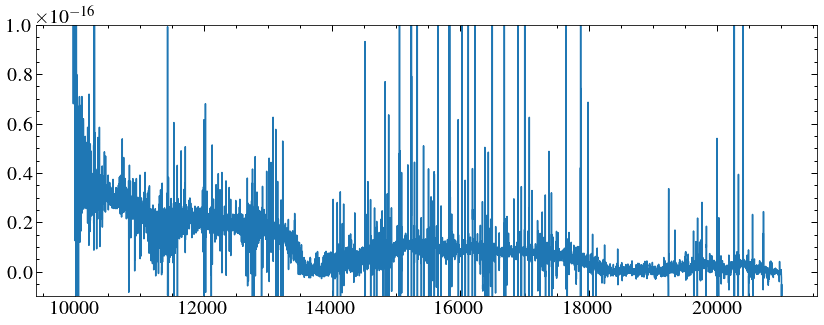

In [33]:
plt.plot(w,f)
plt.ylim(-1e-17, 1e-16)

In [35]:
f= convolve(f,Box1DKernel(50))

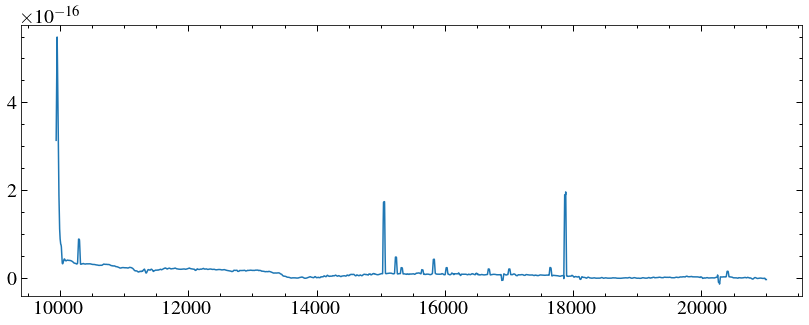

In [13]:
plt.plot(w,f)

Does that look like the bands in the T1 spectrum?

In [14]:
t1_p = Table.read('/home/david/work/muscles/SEDs/trappist-1/phoenix_repo/2560_5.0_0.0_0.0_phoenix_interpolated.txt', format='ascii')

In [16]:
wt, wf = t1_p['WAVELENGTH'], t1_p['FLUX']

In [21]:
tw, tf = resample.bintogrid(wt, wf, dx=1) 
mask = (tw > w[0]) & (tw < w[-1]) 
tw, tf = tw[mask], tf[mask]

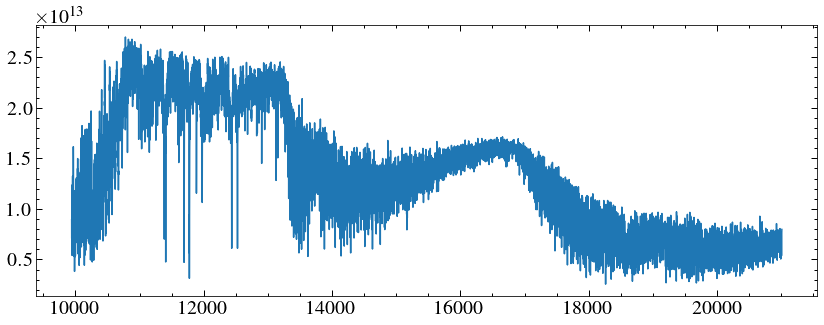

In [22]:
plt.plot(tw, tf)

(-1e-17, 1e-16)

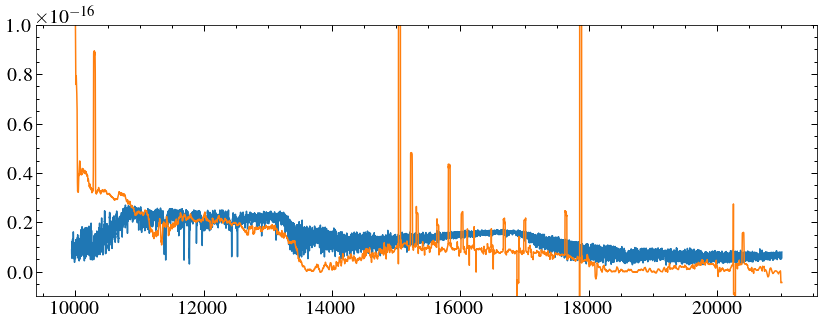

In [36]:
plt.plot(tw, tf/1e30)
plt.plot(w[100:],f[100:])
plt.ylim(-1e-17, 1e-16)

Interesting. Play with scaling

In [40]:
mw, mf = np.loadtxt('da23027g774.dat', unpack=True)
mask = (mw > w[0]) & (mw < w[-1]) 
mw, mf = mw[mask], mf[mask]

(-1e-17, 1e-16)

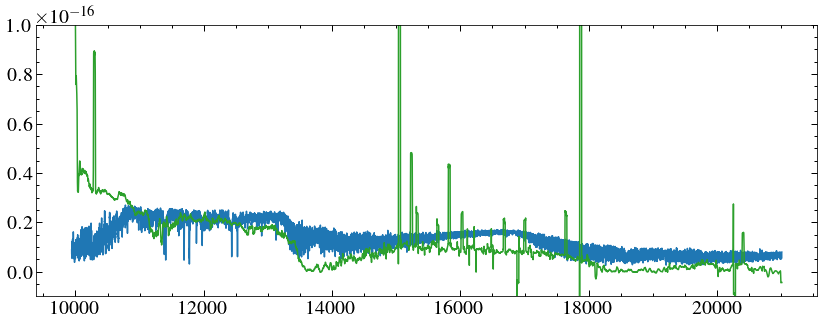

In [41]:
plt.plot(tw, tf/1e30)
plt.plot(mw, mf)
plt.plot(w[100:],f[100:])
plt.ylim(-1e-17, 1e-16)

What about varible NIR? 

In [42]:
for s in sp:
    wi, fi, ei = np.loadtxt(s, unpack=True, skiprows=1)
    fi = convolve(fi,Box1DKernel(50))
    plt.plot(wi, fi)    